In [38]:
! pip install optuna

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
#display(HTML("<style>.jp-RenderedText { font-family: 'Consolas'; }</style>"))
#display(HTML("<style>.jp-RenderedText, .CodeMirror { font-family: 'Consolas'; }</style>"))

In [40]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("/content/drive/My Drive/lg_aimers/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/lg_aimers/original_submission.csv")
city_list = pd.read_csv('/content/drive/My Drive/lg_aimers/oecd_city.csv').iloc[1:,0:1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import re

city_list = city_list.rename(columns = {'#NAME?' : 'name'})
city_list.loc[:,'name'] = city_list['name'].apply( lambda x : x.replace(' ', ''))
city_list['name'] = city_list['name'].str.lower()
country_cities = {}
current_country = None

for ind, row in city_list.iterrows():

    if not re.search(r'\d', row['name']):
        current_country = row['name'].split(':')[1]
        country_cities[current_country] = []

    else:
        if current_country:
            city_name = row['name'].split(':')[1]
            city_name_cleaned = re.sub(r'\s*\([^)]*\)', '', city_name).strip()
            country_cities[current_country].append(city_name_cleaned)

countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
    "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin",
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi",
    "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo", "Costa Rica", "Cote d'Ivoire", "Croatia",
    "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
    "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland", "France",
    "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau",
    "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
    "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "southkorea", "Kosovo",
    "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
    "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania",
    "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique",
    "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia",
    "Norway", "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
    "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
    "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
    "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka",
    "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
    "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine",
    "u.a.e", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City",
    "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe",\
    'us', 'puertorico', 'türkiye', 'usa',\
    'hongkong'
]


countries = list(map(lambda x : x.replace(' ', ''), countries))
countries = [country.lower() for country in countries]

pattern_updated = '|'.join([f'\\b{country}\\b|{country}$' for country in countries])
pattern2 = r'[A-Za-z]{2}\d{5}$'
pattern3 = r'salem|ny|nevada|ohio|kansascity|chulavista|wichita|oh44483|keshena|andersenafb|goleta|cincinnati'
pattern4 = r'madurai|mumbai|ludhiana|bangalore'
pattern5 = r'medellin'
pattern6 = r'macedonia'
pattern7 = r'charlestown'
pattern8 = r'上海'

def classify_country(x):
    if re.search(pattern3, x, re.IGNORECASE):
        return 'unitedstates'
    elif re.search(pattern4, x, re.IGNORECASE):
        return 'india'
    elif re.search(pattern5, x, re.IGNORECASE):
        return 'colombia'
    elif re.search(pattern6, x, re.IGNORECASE):
        return 'northmacedonia'
    elif re.search(pattern7, x, re.IGNORECASE):
        return 'saintkittsandnevis'
    elif re.search(pattern8, x, re.IGNORECASE):
        return 'china'
    else:
        return x


country_patterns = {country: '|'.join(map(re.escape, cities)) for country, cities in country_cities.items()}

def classify_country2(sentence):
    for country, pattern in country_patterns.items():
        if re.search(pattern, sentence, re.IGNORECASE):
            return country
    return sentence

final_map = {'us' : 'unitedstates', 'usa' : 'unitedstates', 'korea' : 'southkorea', 'tã¼rkiye': 'turkey', 'czechia' : 'czechrepublic',
            'slovakia' :'slovakrepublic', 'türkiye' :'turkey'}

In [42]:
import pandas as pd
import re
#import preprocess2
from sklearn.base import BaseEstimator, TransformerMixin

class MyTrnasformer(BaseEstimator, TransformerMixin):
    def __init__(self, pattern_updated, pattern2, classify_country, classify_country2, final_map, countires):
        self.pattern_updated = pattern_updated
        self.pattern2 = pattern2
        self.classify_country = classify_country
        self.classify_country2 = classify_country2
        self.final_map = final_map
        self.countries = countries

        self.bins = [0, 0.1, 0.15, 0.25, 0.35, 0.49, 1.0]
        self.labels = [1, 2, 3, 4, 5, 6]
        self.customer_country_category = None

        self.similar_categories_mapping = {
                'quotation_or_purchase_consultation': 'quotation or purchase consultation',
                'technical consultation': 'technical support',
                'technical': 'technical support',
                'sales': 'sales inquiry'
            }

        self.position_mapping = {
            'ceo/founder': 'CEO/Founder', 'founder': 'CEO/Founder', 'chief executive officer': 'CEO/Founder',
            'ceo/fundador': 'CEO/Founder', 'the big boss': 'CEO/Founder',
            'vice president': 'Vice President', 'vicepresident': 'Vice President', 'vp': 'Vice President',
            'c-level executive': 'C-Level Executive', 'c-levelexecutive': 'C-Level Executive',
            'leadership/executive office/owner': 'C-Level Executive',
            'director': 'Director', 'business unit director': 'Director',
            'associate/analyst': 'Associate/Analyst', 'associate professor': 'Associate/Analyst',
            'assistant professor': 'Associate/Analyst', 'asst prof.': 'Associate/Analyst',
            'entry level': 'Entry Level', 'entrylevel': 'Entry Level',
            'manager': 'Manager', 'gerente': 'Manager',
            'consultant': 'Consultant', 'commercial consultant': 'Consultant',
            'architecture/consult': 'Consultant', 'architect/consultant': 'Consultant',

            'teacher': 'Education Professional', 'educator': 'Education Professional',
            'professor': 'Education Professional', 'physics teacher': 'Education Professional',
            'maths lecturer': 'Education Professional', 'quantitative aptitude faculty': 'Education Professional',
            'english trainer for ielts,toefl,pte,gre,sat exams.': 'Education Professional', 'pgt physics': 'Education Professional',
            'chemistry teacher': 'Education Professional', 'math and physics teacher': 'Education Professional',
            'assistant professor of enlish': 'Education Professional', 'professor of mathematics': 'Education Professional',
            'physics and mathematics teacher': 'Education Professional',
            # 기타 분류
            'other': 'other', 'others': 'other', 'not applicable': 'other', 'other - please specify - cedia association': 'other'

            }


        self.timeline_mapping = {
                # 시간 프레임 관련 값
                'less than 3 months': 'less than 3 months',
                '3 months ~ 6 months': '3 to 6 months',
                '6 months ~ 9 months': '6 to 9 months',
                '9 months ~ 1 year': '9 months to 1 year',
                'more than a year': 'more than a year',
                'less than 6 months': 'less than 6 months',
                '3_months_~_6_months': '3 to 6 months',
                'less_than_3_months': 'less than 3 months',
                '6_months_~_9_months': '6 to 9 months',
                '9_months_~_1_year': '9 months to 1 year',
                'more_than_a_year': 'more than a year',

                # 상황 설명 값
                'quote has been sent to customer.': 'quote sent',
                'client not interested in product..': 'client not interested',
                'being followed up': 'being followed up',
                'update- 7th aug--demo given. customer will confirm next week': 'demo given - follow up',
                'details send': 'details sent',
                'requires detail for tender. no purchase requirement right now.': 'details required for tender',
                'the client is not having any requirement hence closig in system.': 'client has no requirement',
                'discussed with client details mailed.': 'details mailed to client',
                'he is looking for video wall & idb for his office.': 'looking for specific products',
                'details shared': 'details shared',
                'demo to be aligned': 'demo to be scheduled',
                'update- 13th spet--follow up to be done on 15th sept': 'follow up scheduled',
                'partner is already in touch with our rd, orno.': 'partner in touch with representative',
                'rnr': 'no response received',
                'scheduling a meeting': 'meeting scheduled',
                'customer want demo of idb.': 'customer wants demo',
                'already shared quotation through si.': 'quotation shared',
                'quotation shared.': 'quotation shared',
                'duplicate lead': 'duplicate lead',
                'invalid lead': 'invalid lead',
                'demo scheduled for first week feb': 'demo scheduled',
                'forwarded to bdo, being followed up': 'being followed up by business development officer',
                'spoke with custome he want 43" tv': 'customer wants specific product',
                'don’t have budget': 'no budget',
                'client shall get back for exploring demo of idb': 'client will get back regarding demo',
                'already in discussion with partner from bangalore': 'in discussion with partner',
                'require demo price send': 'demo and price inquiry',
                'size not available': 'specific size not available',
                'eol model new model quote requirment after 30 days.': 'end of life model, new model required after 30 days',
                'need to discuss with client in next two months.': 'discussion planned with client',
                'spoken to client, he will check if they need demo and confirm': 'client will confirm about demo',
                '29thsep2021:-no such requirement as of now': 'no requirement as of now',
                'purchase planning after 3 months': 'planning to purchase after 3 months',
                '09-02-2022 requested for boq of requirement': 'bill of quantities requested',
                'converted this lead into opportunity.': 'lead converted into opportunity',
                'demo scheduled for 24th oct': 'demo scheduled',
                'discussed with client. we need to align demo.': 'discussion with client about demo',
                'require demo': 'demo required',
                'client is looking for 86" display with vc solution': 'client looking for specific display with solution',
                'quote sent to customer.': 'quote sent to customer',
                'under discussion': 'under discussion',
                'meeting planned for further discussion': 'meeting planned',
                'customer will come for demo in next week': 'customer will come for demo',
                'he want demo next week': 'demo requested next week',
                'call and discused to custome customer wants demo.': 'customer wants demo, discussed over call',
                'demo planned, will update further status once its completed': 'demo planned and update pending',
                'quote sent, the client is required demo in june': 'quote and demo scheduled in june',
                'will come for the demo': 'client will come for demo',
                'customer has not answering call': 'customer not answering'
            }

        self.dict_inquiry_type = None
        self.dict_customer_type = None
        self.dict_customer_job = None
        self.dict_product_category = None
        self.dict_customer_position = None
        self.dict_expected_timeline = None


    def fit(self, X, y=None):
        df_train = X.copy()

        #inquiry_type
        similar_categories = ['others', 'other_', 'etc.']
        df_train['inquiry_type'].replace(similar_categories, 'other', inplace=True)
        df_train['inquiry_type'] = df_train['inquiry_type'].str.lower()
        similar_categories_mapping = {
            'quotation_or_purchase_consultation': 'quotation or purchase consultation',
            'technical consultation': 'technical support',
            'technical': 'technical support',
            'sales': 'sales inquiry'
        }
        df_train['inquiry_type'] = df_train['inquiry_type'].replace(similar_categories_mapping)
        Y = df_train.copy()

        category_counts = df_train['inquiry_type'].value_counts()
        categories_to_remove = category_counts[category_counts <= 100].index
        df_train.loc[df_train['inquiry_type'].isin(categories_to_remove), 'inquiry_type'] = 'undefined'

        self.dict_inquiry_type = dict(zip(Y['inquiry_type'], df_train['inquiry_type']))  # 기존 : 최종

        #customer_type

        df_train['customer_type'] = df_train['customer_type'].str.lower()
        df_train['customer_type'] = df_train['customer_type'].str.replace(' ', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('/', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('//', '/')
        df_train['customer_type'] = df_train['customer_type'].str.replace('_', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('-', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace(r'/$', '', regex=True)
        df_train['customer_type'] = df_train['customer_type'].str.replace(r'^/', '', regex=True)

        Y = df_train.copy()

        category_counts = df_train['customer_type'].value_counts()
        categories_to_remove = category_counts[category_counts <= 100].index
        df_train.loc[df_train['customer_type'].isin(categories_to_remove), 'customer_type'] = 'undefined'

        self.dict_customer_type = dict(zip(Y['customer_type'], df_train['customer_type']))  # 기존 : 최종

        #customer_job
        df_train['customer_job'] = df_train['customer_job'].str.lower()
        df_train['customer_job'] = df_train['customer_job'].str.replace(' ', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('/', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('//', '/')
        df_train['customer_job'] = df_train['customer_job'].str.replace('_', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('-', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace(r'/$', '', regex=True)
        df_train['customer_job'] = df_train['customer_job'].str.replace(r'^/', '', regex=True)

        df_train['customer_job'] = df_train['customer_job'].replace('others', 'other')
        df_train['customer_job'] = df_train['customer_job'].replace('accountedf_trainec/manager', 'accountmanagement')
        df_train['customer_job'] = df_train['customer_job'].replace('accountspayable', 'accounting')
        specific_values = ['admin', 'administración', 'administration', 'administrative', 'adminisztráció', 'amministrativo',
                           'imagingadministrator', 'itadmin', 'itadministrator', 'networkadministrator', 'pacsadministrator',
                           'platformadministrator', 'systemsadministrator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'admin' if df_train in specific_values else df_train)

        #4.
        df_train['customer_job'] = df_train['customer_job'].replace('administrativeassistant', 'adminassistant')

        #5.
        df_train['customer_job'] = df_train['customer_job'].replace('advertisingandpromotionsteam', 'advertising')
        df_train['customer_job'] = df_train['customer_job'].replace('storepromotions', 'advertising')
        df_train['customer_job'] = df_train['customer_job'].replace('tradeshowevent', 'advertising')

        #6.
        specific_values2 = ['architect', 'architect/owner', 'architectassinteriores', 'arquitecto/consultor', 'projectarchitect']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'architect' if df_train in specific_values2 else df_train)

        #7.
        specific_values3 = ['artanddesign','arte_e_design', 'arteydiseño','artist,leadonequipmentselection', 'arts_and_design', 'artsanddesign']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'artist' if df_train in specific_values3 else df_train)

        #8.
        specific_values4 = ['assistinservingfood', 'serving', 'servingfood', 'servingrobot', 'waiter']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'serving' if df_train in specific_values4 else df_train)

        #9.
        specific_values5 = ['a/vprojectmanager', 'avestimator', 'avprojectmanager', 'avtech', 'avtechnician']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'avtechnician' if df_train in specific_values5 else df_train)

        #10.
        specific_values6 = ['authorize(youareresponsibleformakingthefinaldecision)', 'purchasingauthority']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'authorizer' if df_train in specific_values6 else df_train)

        #11.
        df_train['customer_job'] = df_train['customer_job'].replace('publicbidder', 'bidder')

        #12.
        specific_values7 = ['business_development', 'businessdevelopment']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'businessdevelopment' if df_train in specific_values7 else df_train)

        #13.
        specific_values8 = ['cctvmonetoring', 'cctvview']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'cctvoperator' if df_train in specific_values8 else df_train)

        #14.
        specific_values9 = ['ceo', 'ceo/founder', 'chief', 'cleveledf_trainecutive', 'coo', 'decider', 'decisionmaker',
                            'finalapproval', 'head', 'president', 'presidentforsennco', 'thebigboss', 'underboss',
                            'vicepresident', 'vp/gm']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'chief' if df_train in specific_values9 else df_train)

        #15.
        specific_values10 = ['chiefeng', 'chiefengineer', 'chiefofengineering']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'chiefengineer' if df_train in specific_values10 else df_train)

        #16.
        specific_values11 = ['chirurgien', 'cirugano', 'doctor', 'főorvos',  'profesionaldecirugía', 'surgeryprofessional',
                             'surgeryprofessional\u200b']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'doctor' if df_train in specific_values11 else df_train)

        #17.
        specific_values12 = ['contractor', 'cintractor', 'managingcontractor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'contractor' if df_train in specific_values12 else df_train)

        #18.
        specific_values13 = ['consultant', 'consultant,cabinetfabricator', 'consultant/purchaser', 'consultent', 'consulting']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'consultant' if df_train in specific_values13 else df_train)

        #19.
        specific_values14 = ['coordinator', 'corporate/office', 'correspondence', 'costaravteam']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'corporate' if df_train in specific_values14 else df_train)

        #20.
        specific_values15 = ['contentcreation,eqconsultant', 'creativedirector']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'creator' if df_train in specific_values15 else df_train)

        #21.
        specific_values16 = ['design', 'design/build', 'design/purchaser', 'designandprovideequipment', 'designer',
                             'designer,creativetechnologist', 'designer,producer', 'designers', 'designere/budget',
                             'designerpurchaser', 'design/purchaser', 'graphicdesign', 'kreation_und_design',
                             'kreationunddesign', 'művészet_és_design']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designer' if df_train in specific_values16 else df_train)

        #22.
        specific_values17 = ['design/insttrain/training/support', 'designandinsttrain', 'designandinsttrainationcompany', 'designer/insttrainer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designinsttrainer' if df_train in specific_values17 else df_train)

        #23.
        specific_values18 = ['designengineer', 'designer/engineer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designengineer' if df_train in specific_values18 else df_train)

        #24.
        specific_values19 = ['desicionmaker', 'design/decisionmaker', 'generalmanager(decisionmaker)', 'technical/decisionmaker']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'decisionmaker' if df_train in specific_values19 else df_train)

        #25.
        specific_values20 = ['designer/pm/gc', 'designer/projectmanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'desingpm' if df_train in specific_values20 else df_train)

        #26.
        specific_values21 = ['developer', 'developer/property', 'softwaredeveloper']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'developer' if df_train in specific_values21 else df_train)

        #27.
        specific_values22 = ['digitaldisplayvssignageneed', 'digitalsignage']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'digitalsignage' if df_train in specific_values22 else df_train)

        #28.
        specific_values23 = ['directeurtechnique', 'director', 'director,it', 'directorcomercial',
                             'directorit', 'directorofengineering', 'directoroffinance', 'directorofit',
                             'directoroflodging','directorofoperations', 'directorpurchaser', 'engineeringdirector',
                             'f&bdirectorforbicyclecasino', "i'mdirectingit", 'itdairector',  'itdirector',  'managingdirector',
                             'overseer',  'projectdirector', 'purchasingdirector', 'supervisor', 'technicaldirector']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'director' if df_train in specific_values23 else df_train)

        #29.
        specific_values24 = ['distribuidor', 'distributor', 'distributorquotation']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'distributor' if df_train in specific_values24 else df_train)

        #30.
        specific_values25 = ['education', 'educator', 'highereducation(college&university)', 'institute&academy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'educator' if df_train in specific_values25 else df_train)

        #31.
        specific_values26 = ['engineer', 'engineering', 'engineering&technical', 'engineering,design,andinsttrain',
                             'hardwaredesignengineer', 'projectengineer', 'principalengineer', 'seniordesignengineer',
                             'systemengineer', 'systemsengineer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'engineer' if df_train in specific_values26 else df_train)

        #32.
        specific_values27 = ['engagementedf_trainecutive', 'engineering&technicaledf_trainecutive', 'edf_trainecutive', 'edf_trainecution',
                             'marketingedf_trainecutive', 'financeedf_trainecutive', 'operationsedf_trainecutive', 'principal',  'principalincharge',
                             'salesedf_trainecutive']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'edf_trainecutive' if df_train in specific_values27 else df_train)

        #33.
        specific_values28 = ['eventmarketing', 'fieldmarketing', 'marketing', 'marketingcoordinator',
                             'marketingoperations', 'productmarketing', 'technicalmarketing']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'marketing' if df_train in specific_values28 else df_train)

        #34.
        specific_values29 = ['equipmentandappprovider', 'equipmentcustodian', 'equipmentplanner', 'equipmentselection']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'equipment' if df_train in specific_values29 else df_train)

        #35.
        specific_values30 = ['facilitator', 'facilitatorinsttrainationservices', 'facilities', 'facilitiesandoperations',
                             'facilityadministrator', 'facilitymanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'facilitator' if df_train in specific_values30 else df_train)

        #36.
        specific_values31 = ['field/outsidesales', 'sale', 'sales', 'salesman', 'salesmanager',
                             'salesoperations', 'technicalsales', 'salesrep', 'salesengineering', 'sellerinsttrainer',
                             'vendite', 'vertrieb', 'értékesítés']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'sales' if df_train in specific_values31 else df_train)

        #37.
        specific_values32 = ['finance', 'finanzas', 'finanzen', 'pénzügy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'finance' if df_train in specific_values32 else df_train)

        #38.
        specific_values33 = ['gc', 'generalcontractor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalcontractor' if df_train in specific_values33 else df_train)

        #39.
        specific_values34 = ['genelmüdür', 'generalmanagement', 'generalmanager', 'generalmanagerpurchaser', 'generamanager',
                             'globtraineadofproduction','gm', 'gm/partowner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalmanager' if df_train in specific_values34 else df_train)

        #40.
        specific_values35 = ['generalmanagerprojectmanager', 'gestión_de_proyectos']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalprojectmanager' if df_train in specific_values35 else df_train)

        #41.
        specific_values36 = ['hr','human_resources', 'humanresources', 'hrposting']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'humanresource' if df_train in specific_values36 else df_train)

        #42.
        specific_values37 = ['healthcare_services', 'healthcareprofessionals', 'healthcareservices', 'mentalhealth']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'healthcare' if df_train in specific_values37 else df_train)

        #43.
        specific_values38 = ['helpdesk/desktopservices', 'helpdeskspecialist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'helpdesk' if df_train in specific_values38 else df_train)

        #44.
        specific_values39 = ['implement', 'informatics,touchcapability', 'information_technology', 'informationtechnology',
                             'informationtechnology\u200b', 'it', 'it/software', 'itdepartment', 'ittech', 'itsupport',
                             'itspecialist', 'itintegrator', 'ithardwaretechnician', 'itinformationtechnology', 'officeit']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'it' if df_train in specific_values39 else df_train)

        #45.
        specific_values40 = ['insttrainationandpurchaser', 'insttrainer', 'insttrainer/salesrep', 'insttrainer/systemintegrater',
                             'postinsttrainsupportandservice',  'planningandinsttraination', 'systeminsttrainer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'insttrain' if df_train in specific_values40 else df_train)

        #46.
        specific_values41 = ['integrador', 'integration', 'integrator', 'intergrator', 'si', 'specifier/integrator',
                             'systemdesigner,integrator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'integrator' if df_train in specific_values41 else df_train)

        #47.
        specific_values42 = ['interiordesigner', 'interiorstylist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'interior' if df_train in specific_values42 else df_train)

        #48.
        specific_values43 = ['instructor', 'teacher', 'teaching']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'instructor' if df_train in specific_values43 else df_train)

        #49.
        specific_values44 = ['lead', 'leaddesigner', 'leadengineer', 'leader', 'itprojectlead',
                             'projectlead', 'teamlead', 'teamleader']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'leader' if df_train in specific_values44 else df_train)

        #50.
        specific_values45 = ['medicalsolutionprovider', 'medicalsolutionprovider\u200b']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'medicalsolutionprovider' if df_train in specific_values45 else df_train)

        #51.
        specific_values46 = ['maintenance', 'maintenancesupervisor', 'maintenancetechnician']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'maintenance' if df_train in specific_values46 else df_train)

        #52.
        specific_values47 = ['management',  'manager', 'managgere', 'managingemployee', 'managingpartner', 'manger',
                             'officemanager', 'üzemeltetés']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'manager' if df_train in specific_values47 else df_train)

        #53.
        specific_values48 = ['manufacturer', 'manufacturingfactory/plant']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'manufacturer' if df_train in specific_values48 else df_train)

        #54.
        specific_values49 = ['media_and_communication', 'media_e_comunicazione', 'mediaandcommunication',
                             'mediaandcommunications',  'medios_de_comunicación', 'medien_und_kommunikation',
                             'média_és_kommunikáció']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'mediaandcommunication' if df_train in specific_values49 else df_train)

        #55.
        specific_values50 = ['military_and_protective_services', 'militaryandprotectiveservices']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'military' if df_train in specific_values50 else df_train)

        #56.
        specific_values51 = ['obtainquotes,processpurchase', 'planner/purchaser', 'purchase', 'purchaseandinsttrain',
                             'purchasedept', 'purchaser', 'purchaser,itandinsttrainer', 'purchasers', 'purchasing',
                             'purchasingagent', 'purchasingcoordinator','purchsing']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'purchase' if df_train in specific_values51 else df_train)

        #57.
        specific_values52 = ['operaciones', 'operations']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'operation' if df_train in specific_values52 else df_train)

        #58.
        specific_values53 = ['operationsmanager', 'opsmgr']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'operationmanager' if df_train in specific_values53 else df_train)

        #59.
        specific_values54 = ['product_management', 'productmanagement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'productmanager' if df_train in specific_values54 else df_train)

        #60.
        specific_values55 = ['pm', 'producer/projectmanager', 'program_and_project_management', 'program_and_project_manager',
                             'program_és_projektmenedzsment', 'programandprojectmanagement',  'programm_und_projektmanagement',
                             'programmundprojektmanagement',  'projectcoordinator', 'projectadministrator', 'programdirectors',
                             'projectionmanager', 'projectmanage', 'projectmanager', 'projectmanager/designer',
                             'projectmanager/estimator', 'projectmanager/principal','projectsales/manage',
                             'projektmenedzsment\tprogramandprojectmanagement', 'projectdesigner','projectfacilitator',
                             'projecthead', 'projectrmgmt', 'r&dprojectmanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'projectmanager' if df_train in specific_values55 else df_train)

        #61.
        specific_values56 =  ['productresearch', 'productresearcher', 'projectresearcher', 'research/insttrain',
                              'researchproductsandprices', 'researchandinstalaltion']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'research' if df_train in specific_values56 else df_train)

        #62.
        specific_values57 = ['medicalimagingspecialist', 'profesionalderadiología', 'spécialiste_en_imagerie_médicale']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'medicalimagingspecialist' if df_train in specific_values57 else df_train)

        #63.
        specific_values58 = ['proprietário(a)', 'propertyowner', 'ownerrepresentation', 'owningcompany',
                             'ownnermarketingdirector', 'owner/projectmanager', 'businessowner', 'productowner',
                             'buildingowner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'owner' if df_train in specific_values58 else df_train)

        #64.
        specific_values59 = ['partscoordinator', 'buyer,coordinating', 'servicecoordinator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'coordinator' if df_train in specific_values59 else df_train)

        #65.
        specific_values60 = ['procurement', 'procurementspecialist', 'procurment', 'sourcing/procurement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'procurement' if df_train in specific_values60 else df_train)

        #66.
        specific_values61 = ['quality_assurance', 'qualityassurance']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'qualityassurance' if df_train in specific_values61 else df_train)

        #67.
        specific_values62 = [ 'quotationcurator',  'quotegathering/proposertoowner', 'quotingproject', 'sourcing',
                             'sourcing&quotingforenduser']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'quotation' if df_train in specific_values62 else df_train)

        #68.
        specific_values63 = ['radiology_professional',  'radiologyprofessional']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'radiology' if df_train in specific_values63 else df_train)

        #69.
        specific_values64 = ['recommend', 'recommend(yourecommendspecificproductsortechnologiesforthesolution)',
                             'recommendation', 'recommender']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'recommend' if df_train in specific_values64 else df_train)

        #70.
        specific_values65 = ['requirementsandbuyer', 'buyer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'buyer' if df_train in specific_values65 else df_train)

        #71.
        specific_values66 = ['research&development', 'researchanddevelopement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'researchanddevelopment' if df_train in specific_values66 else df_train)

        #72.
        specific_values67 = ['reseller', 'reseller/integrator', 'technicaladvisor,reseller', 'vendor/reseller']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'reseller' if df_train in specific_values67 else df_train)

        #73.
        specific_values68 = ['retailer/insttrainer', 'revendedor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'retailer' if df_train in specific_values68 else df_train)

        #74.
        specific_values69 = ['display', 'displayourproducts', 'restaurantdisplay', 'usingforwindowdisplay']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'display' if df_train in specific_values69 else df_train)

        #75.
        specific_values70 = ['energy', 'renewableenergy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'energy' if df_train in specific_values70 else df_train)

        #76.
        specific_values71 = ['changetv', 'replacementtv', 'replacingtv']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'changetv' if df_train in specific_values71 else df_train)

        #77.
        specific_values72 = ['signageforanattraction', 'signagemanager', 'signagesubcontractorp/m', 'signcompany',
                             'slidingpicturesofbeautysalon']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'signage' if df_train in specific_values72 else df_train)

        #78.
        specific_values73 = ['solutionadvisor', 'solutionengineer', 'solutionprovider', 'solutionsarchitect',
                             'solutionsproviderandspecifier', 'softwaresolution']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'solution' if df_train in specific_values73 else df_train)

        #79.
        specific_values74 = ['systemsdesign', 'systemsdesigner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'systemdesigner' if df_train in specific_values74 else df_train)

        #80.
        specific_values75 = ['strategiccommunications', 'strategy&operationsspecialist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'strategy' if df_train in specific_values75 else df_train)

        #81.
        specific_values76 = ['support', 'support/facilitator,designer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'support' if df_train in specific_values76 else df_train)

        #82.
        specific_values77 = ['supplier', 'supplierandinsttraination']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'supplier' if df_train in specific_values77 else df_train)

        #83.
        specific_values78 = ['tech', 'technical', 'technologyconsultant', 'technologydesigner', 'techservice',
                             'avtechnician', 'fidf_trainingtv', 'emergingtechnology/innovation']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'tech' if df_train in specific_values78 else df_train)

        #84.
        df_train['customer_job'] = df_train['customer_job'].replace('tierarzt', 'vat')


        Y = df_train.copy()
        category_counts = df_train['customer_job'].value_counts()
        categories_to_remove = category_counts[category_counts <= 40].index
        df_train.loc[df_train['customer_job'].isin(categories_to_remove), 'customer_job'] = 'undefined'
        df_train['customer_job'].value_counts()

        self.dict_customer_job = dict(zip(Y['customer_job'], df_train['customer_job']))  # 기존 : 최종




        # product_category

        df_train['product_category'] = df_train['product_category'].str.lower()
        # 1.
        specific2_values = ['videowtrainsignage', 'ledsignage', 'interactivesignage', 'oledsignage', 'standardsignage',
                            'highbrightnesssignage', 'specialsignage', 'ur640s', 'smarttvsignage', 'ur640', 'uhdsignage',
                            'digitalsignage', 'tvsignage', 'monitorsignagecommercialtv']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'signage' if x in specific2_values else x)

        # 2.
        specific2_values2 = ['hoteltv', 'hospitaltv', 'commercialtv', 'commercialtvtv', 'htv', '43us660h0sdawz']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'tv' if x in specific2_values2 else x)

        # 3.
        specific2_values3 = ['pc', 'laptop']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'pclaptop' if x in specific2_values3 else x)

        # 4.
        specific2_values4 = ['solaress', 'solarsystemac']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'solar' if x in specific2_values4 else x)

        # 5.
        specific2_values5 = ['solarchiller', 'systemacchiller']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'chiller' if x in specific2_values5 else x)

        # 6.
        specific2_values6 = ['monitorsignagemoniormonitortv', 'monitorpc', 'moniormonitortvtv', 'computermonitors']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'monitor' if x in specific2_values6 else x)

        # 7.
        specific2_values7 = ['control', 'highbrightness', 'softwaresolution', 'signagecaresolution', 'technicalsupport',
                             'services', 'salesinquiry', 'solaraircare', 'chilleraircare', 'systemacaircare']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'support' if x in specific2_values7 else x)

        # 8.
        specific2_values8 = ['medicaldisplay', 'commercialdisplay', 'medicaldisplays', 'led', 'ledtraininone', 'fhdseries',
                             'oled']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'display' if x in specific2_values8 else x)

        # 9.
        specific2_values9 = ['multisplit', 'singlesplit', 'multiinverter', 'trainlgvrfsystems', 'multiv5air', 'multivwater5',
                             'multiv5vrf', 'vrfmultisplitsinglesplit', 'vrfmultisplitsinglesplitchiller', 'vrfsinglesplit',
                             'vrfmultisplit', 'ogrzewaniepompyciepa']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'vrf' if x in specific2_values9 else x)

        # 10.
        specific2_values10 = ['videowtrain', 'videowtrainrmk', 'projector', 'video']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'videoprojector' if x in specific2_values10 else x)

        # 11.
        specific2_values11 = ['heating', 'athermodynamicwaterheater']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'heater' if x in specific2_values11 else x)

        # 12.
        specific2_values12 = ['idb', 'educationcreateboard']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'interactivedigitalboard' if x in specific2_values12 else x)

        # 13.
        specific2_values13 = ['lgonequickseries', 'onequickseries', 'lgonequick']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'onequick' if x in specific2_values13 else x)

        # 14.
        specific2_values14 = ['webos', 'procentric', 'clouddevice']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'oscloud' if x in specific2_values14 else x)

        # 15.
        specific2_values15 = ['rac', 'tetooucasseteinverter', 'arcondicionadoresidencial', 'residentialairconditioner',
                              'aireacondicionadoresidencial']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'airconditioner' if x in specific2_values15 else x)

        # 16.
        specific2_values16 = ['robots']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'robot' if x in specific2_values16 else x)

         # 17.
        specific2_values17 = ['outros', 'otros', 'others']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'other' if x in specific2_values17 else x)

        Y = df_train.copy()
        value_counts = df_train['product_category'].value_counts()
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'undefined' if pd.isna(x) or value_counts.get(x, 0) < 50 or value_counts.get(x, 0) == 53 else x)

        self.dict_product_category = dict(zip(Y['product_category'], df_train['product_category']))


        #customer_position

        df_train['customer_position'] = df_train['customer_position'].replace(self.position_mapping)
        df_train['customer_position'] = df_train['customer_position'].str.lower()
        df_train['customer_position'] = df_train['customer_position'].str.replace(' ', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('/', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('//', '/')
        df_train['customer_position'] = df_train['customer_position'].str.replace('_', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('-', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace(r'/$', '', regex=True)
        df_train['customer_position'] = df_train['customer_position'].str.replace(r'^/', '', regex=True)

        Y = df_train.copy()
        category_counts = df_train['customer_position'].value_counts()
        categories_to_remove = category_counts[category_counts <= 400].index
        df_train.loc[df_train['customer_position'].isin(categories_to_remove), 'customer_position'] = 'undefined'
        self.dict_customer_position = dict(zip(Y['customer_position'], df_train['customer_position']))


        #expected_timeline

        df_train['expected_timeline'] = df_train['expected_timeline'].replace(self.timeline_mapping)
        df_train['expected_timeline'] = df_train['expected_timeline'].str.lower()
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('/', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('.', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('~', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(' ', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('//', '/')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('_', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('-', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(r'/$', '', regex=True)
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(r'^/', '', regex=True)

        Y = df_train.copy()
        category_counts = df_train['expected_timeline'].value_counts()
        categories_to_remove = category_counts[category_counts <= 110].index
        df_train.loc[df_train['expected_timeline'].isin(categories_to_remove), 'expected_timeline'] = 'undefined'

        self.dict_expected_timeline = dict(zip(Y['expected_timeline'], df_train['expected_timeline']))

        return self


    def transform(self, X, y=None):

        df_train = X.copy()


        #inquiry_type
        similar_categories = ['others', 'other_', 'etc.']
        df_train['inquiry_type'].replace(similar_categories, 'other', inplace=True)
        df_train['inquiry_type'] = df_train['inquiry_type'].str.lower()
        similar_categories_mapping = {
            'quotation_or_purchase_consultation': 'quotation or purchase consultation',
            'technical consultation': 'technical support',
            'technical': 'technical support',
            'sales': 'sales inquiry'
        }
        df_train['inquiry_type'] = df_train['inquiry_type'].replace(similar_categories_mapping)
        df_train['inquiry_type'] = df_train['inquiry_type'].apply\
            (lambda x: self.dict_inquiry_type[x] if x in self.dict_inquiry_type else 'undefined')



        #customer_type

        df_train['customer_type'] = df_train['customer_type'].str.lower()
        df_train['customer_type'] = df_train['customer_type'].str.replace(' ', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('/', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('//', '/')
        df_train['customer_type'] = df_train['customer_type'].str.replace('_', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace('-', '')
        df_train['customer_type'] = df_train['customer_type'].str.replace(r'/$', '', regex=True)
        df_train['customer_type'] = df_train['customer_type'].str.replace(r'^/', '', regex=True)

        df_train['customer_type'] = df_train['customer_type'].apply\
            (lambda x: self.dict_customer_type[x] if x in self.dict_customer_type else 'undefined')



        #customer_job
        df_train['customer_job'] = df_train['customer_job'].str.lower()
        df_train['customer_job'] = df_train['customer_job'].str.replace(' ', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('/', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('//', '/')
        df_train['customer_job'] = df_train['customer_job'].str.replace('_', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace('-', '')
        df_train['customer_job'] = df_train['customer_job'].str.replace(r'/$', '', regex=True)
        df_train['customer_job'] = df_train['customer_job'].str.replace(r'^/', '', regex=True)


        df_train['customer_job'] = df_train['customer_job'].replace('others', 'other')
        df_train['customer_job'] = df_train['customer_job'].replace('accountedf_trainec/manager', 'accountmanagement')
        df_train['customer_job'] = df_train['customer_job'].replace('accountspayable', 'accounting')
        specific_values = ['admin', 'administración', 'administration', 'administrative', 'adminisztráció', 'amministrativo',
                           'imagingadministrator', 'itadmin', 'itadministrator', 'networkadministrator', 'pacsadministrator',
                           'platformadministrator', 'systemsadministrator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'admin' if df_train in specific_values else df_train)

        #4.
        df_train['customer_job'] = df_train['customer_job'].replace('administrativeassistant', 'adminassistant')

        #5.
        df_train['customer_job'] = df_train['customer_job'].replace('advertisingandpromotionsteam', 'advertising')
        df_train['customer_job'] = df_train['customer_job'].replace('storepromotions', 'advertising')
        df_train['customer_job'] = df_train['customer_job'].replace('tradeshowevent', 'advertising')

        #6.
        specific_values2 = ['architect', 'architect/owner', 'architectassinteriores', 'arquitecto/consultor', 'projectarchitect']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'architect' if df_train in specific_values2 else df_train)

        #7.
        specific_values3 = ['artanddesign','arte_e_design', 'arteydiseño','artist,leadonequipmentselection', 'arts_and_design', 'artsanddesign']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'artist' if df_train in specific_values3 else df_train)

        #8.
        specific_values4 = ['assistinservingfood', 'serving', 'servingfood', 'servingrobot', 'waiter']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'serving' if df_train in specific_values4 else df_train)

        #9.
        specific_values5 = ['a/vprojectmanager', 'avestimator', 'avprojectmanager', 'avtech', 'avtechnician']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'avtechnician' if df_train in specific_values5 else df_train)

        #10.
        specific_values6 = ['authorize(youareresponsibleformakingthefinaldecision)', 'purchasingauthority']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'authorizer' if df_train in specific_values6 else df_train)

        #11.
        df_train['customer_job'] = df_train['customer_job'].replace('publicbidder', 'bidder')

        #12.
        specific_values7 = ['business_development', 'businessdevelopment']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'businessdevelopment' if df_train in specific_values7 else df_train)

        #13.
        specific_values8 = ['cctvmonetoring', 'cctvview']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'cctvoperator' if df_train in specific_values8 else df_train)

        #14.
        specific_values9 = ['ceo', 'ceo/founder', 'chief', 'cleveledf_trainecutive', 'coo', 'decider', 'decisionmaker',
                            'finalapproval', 'head', 'president', 'presidentforsennco', 'thebigboss', 'underboss',
                            'vicepresident', 'vp/gm']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'chief' if df_train in specific_values9 else df_train)

        #15.
        specific_values10 = ['chiefeng', 'chiefengineer', 'chiefofengineering']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'chiefengineer' if df_train in specific_values10 else df_train)

        #16.
        specific_values11 = ['chirurgien', 'cirugano', 'doctor', 'főorvos',  'profesionaldecirugía', 'surgeryprofessional',
                             'surgeryprofessional\u200b']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'doctor' if df_train in specific_values11 else df_train)

        #17.
        specific_values12 = ['contractor', 'cintractor', 'managingcontractor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'contractor' if df_train in specific_values12 else df_train)

        #18.
        specific_values13 = ['consultant', 'consultant,cabinetfabricator', 'consultant/purchaser', 'consultent', 'consulting']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'consultant' if df_train in specific_values13 else df_train)

        #19.
        specific_values14 = ['coordinator', 'corporate/office', 'correspondence', 'costaravteam']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'corporate' if df_train in specific_values14 else df_train)

        #20.
        specific_values15 = ['contentcreation,eqconsultant', 'creativedirector']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'creator' if df_train in specific_values15 else df_train)

        #21.
        specific_values16 = ['design', 'design/build', 'design/purchaser', 'designandprovideequipment', 'designer',
                             'designer,creativetechnologist', 'designer,producer', 'designers', 'designere/budget',
                             'designerpurchaser', 'design/purchaser', 'graphicdesign', 'kreation_und_design',
                             'kreationunddesign', 'művészet_és_design']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designer' if df_train in specific_values16 else df_train)

        #22.
        specific_values17 = ['design/insttrain/training/support', 'designandinsttrain', 'designandinsttrainationcompany', 'designer/insttrainer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designinsttrainer' if df_train in specific_values17 else df_train)

        #23.
        specific_values18 = ['designengineer', 'designer/engineer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'designengineer' if df_train in specific_values18 else df_train)

        #24.
        specific_values19 = ['desicionmaker', 'design/decisionmaker', 'generalmanager(decisionmaker)', 'technical/decisionmaker']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'decisionmaker' if df_train in specific_values19 else df_train)

        #25.
        specific_values20 = ['designer/pm/gc', 'designer/projectmanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'desingpm' if df_train in specific_values20 else df_train)

        #26.
        specific_values21 = ['developer', 'developer/property', 'softwaredeveloper']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'developer' if df_train in specific_values21 else df_train)

        #27.
        specific_values22 = ['digitaldisplayvssignageneed', 'digitalsignage']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'digitalsignage' if df_train in specific_values22 else df_train)

        #28.
        specific_values23 = ['directeurtechnique', 'director', 'director,it', 'directorcomercial',
                             'directorit', 'directorofengineering', 'directoroffinance', 'directorofit',
                             'directoroflodging','directorofoperations', 'directorpurchaser', 'engineeringdirector',
                             'f&bdirectorforbicyclecasino', "i'mdirectingit", 'itdairector',  'itdirector',  'managingdirector',
                             'overseer',  'projectdirector', 'purchasingdirector', 'supervisor', 'technicaldirector']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'director' if df_train in specific_values23 else df_train)

        #29.
        specific_values24 = ['distribuidor', 'distributor', 'distributorquotation']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'distributor' if df_train in specific_values24 else df_train)

        #30.
        specific_values25 = ['education', 'educator', 'highereducation(college&university)', 'institute&academy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'educator' if df_train in specific_values25 else df_train)

        #31.
        specific_values26 = ['engineer', 'engineering', 'engineering&technical', 'engineering,design,andinsttrain',
                             'hardwaredesignengineer', 'projectengineer', 'principalengineer', 'seniordesignengineer',
                             'systemengineer', 'systemsengineer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'engineer' if df_train in specific_values26 else df_train)

        #32.
        specific_values27 = ['engagementedf_trainecutive', 'engineering&technicaledf_trainecutive', 'edf_trainecutive', 'edf_trainecution',
                             'marketingedf_trainecutive', 'financeedf_trainecutive', 'operationsedf_trainecutive', 'principal',  'principalincharge',
                             'salesedf_trainecutive']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'edf_trainecutive' if df_train in specific_values27 else df_train)

        #33.
        specific_values28 = ['eventmarketing', 'fieldmarketing', 'marketing', 'marketingcoordinator',
                             'marketingoperations', 'productmarketing', 'technicalmarketing']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'marketing' if df_train in specific_values28 else df_train)

        #34.
        specific_values29 = ['equipmentandappprovider', 'equipmentcustodian', 'equipmentplanner', 'equipmentselection']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'equipment' if df_train in specific_values29 else df_train)

        #35.
        specific_values30 = ['facilitator', 'facilitatorinsttrainationservices', 'facilities', 'facilitiesandoperations',
                             'facilityadministrator', 'facilitymanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'facilitator' if df_train in specific_values30 else df_train)

        #36.
        specific_values31 = ['field/outsidesales', 'sale', 'sales', 'salesman', 'salesmanager',
                             'salesoperations', 'technicalsales', 'salesrep', 'salesengineering', 'sellerinsttrainer',
                             'vendite', 'vertrieb', 'értékesítés']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'sales' if df_train in specific_values31 else df_train)

        #37.
        specific_values32 = ['finance', 'finanzas', 'finanzen', 'pénzügy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'finance' if df_train in specific_values32 else df_train)

        #38.
        specific_values33 = ['gc', 'generalcontractor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalcontractor' if df_train in specific_values33 else df_train)

        #39.
        specific_values34 = ['genelmüdür', 'generalmanagement', 'generalmanager', 'generalmanagerpurchaser', 'generamanager',
                             'globtraineadofproduction','gm', 'gm/partowner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalmanager' if df_train in specific_values34 else df_train)

        #40.
        specific_values35 = ['generalmanagerprojectmanager', 'gestión_de_proyectos']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'generalprojectmanager' if df_train in specific_values35 else df_train)

        #41.
        specific_values36 = ['hr','human_resources', 'humanresources', 'hrposting']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'humanresource' if df_train in specific_values36 else df_train)

        #42.
        specific_values37 = ['healthcare_services', 'healthcareprofessionals', 'healthcareservices', 'mentalhealth']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'healthcare' if df_train in specific_values37 else df_train)

        #43.
        specific_values38 = ['helpdesk/desktopservices', 'helpdeskspecialist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'helpdesk' if df_train in specific_values38 else df_train)

        #44.
        specific_values39 = ['implement', 'informatics,touchcapability', 'information_technology', 'informationtechnology',
                             'informationtechnology\u200b', 'it', 'it/software', 'itdepartment', 'ittech', 'itsupport',
                             'itspecialist', 'itintegrator', 'ithardwaretechnician', 'itinformationtechnology', 'officeit']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'it' if df_train in specific_values39 else df_train)

        #45.
        specific_values40 = ['insttrainationandpurchaser', 'insttrainer', 'insttrainer/salesrep', 'insttrainer/systemintegrater',
                             'postinsttrainsupportandservice',  'planningandinsttraination', 'systeminsttrainer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'insttrain' if df_train in specific_values40 else df_train)

        #46.
        specific_values41 = ['integrador', 'integration', 'integrator', 'intergrator', 'si', 'specifier/integrator',
                             'systemdesigner,integrator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'integrator' if df_train in specific_values41 else df_train)

        #47.
        specific_values42 = ['interiordesigner', 'interiorstylist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'interior' if df_train in specific_values42 else df_train)

        #48.
        specific_values43 = ['instructor', 'teacher', 'teaching']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'instructor' if df_train in specific_values43 else df_train)

        #49.
        specific_values44 = ['lead', 'leaddesigner', 'leadengineer', 'leader', 'itprojectlead',
                             'projectlead', 'teamlead', 'teamleader']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'leader' if df_train in specific_values44 else df_train)

        #50.
        specific_values45 = ['medicalsolutionprovider', 'medicalsolutionprovider\u200b']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'medicalsolutionprovider' if df_train in specific_values45 else df_train)

        #51.
        specific_values46 = ['maintenance', 'maintenancesupervisor', 'maintenancetechnician']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'maintenance' if df_train in specific_values46 else df_train)

        #52.
        specific_values47 = ['management',  'manager', 'managgere', 'managingemployee', 'managingpartner', 'manger',
                             'officemanager', 'üzemeltetés']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'manager' if df_train in specific_values47 else df_train)

        #53.
        specific_values48 = ['manufacturer', 'manufacturingfactory/plant']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'manufacturer' if df_train in specific_values48 else df_train)

        #54.
        specific_values49 = ['media_and_communication', 'media_e_comunicazione', 'mediaandcommunication',
                             'mediaandcommunications',  'medios_de_comunicación', 'medien_und_kommunikation',
                             'média_és_kommunikáció']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'mediaandcommunication' if df_train in specific_values49 else df_train)

        #55.
        specific_values50 = ['military_and_protective_services', 'militaryandprotectiveservices']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'military' if df_train in specific_values50 else df_train)

        #56.
        specific_values51 = ['obtainquotes,processpurchase', 'planner/purchaser', 'purchase', 'purchaseandinsttrain',
                             'purchasedept', 'purchaser', 'purchaser,itandinsttrainer', 'purchasers', 'purchasing',
                             'purchasingagent', 'purchasingcoordinator','purchsing']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'purchase' if df_train in specific_values51 else df_train)

        #57.
        specific_values52 = ['operaciones', 'operations']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'operation' if df_train in specific_values52 else df_train)

        #58.
        specific_values53 = ['operationsmanager', 'opsmgr']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'operationmanager' if df_train in specific_values53 else df_train)

        #59.
        specific_values54 = ['product_management', 'productmanagement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'productmanager' if df_train in specific_values54 else df_train)

        #60.
        specific_values55 = ['pm', 'producer/projectmanager', 'program_and_project_management', 'program_and_project_manager',
                             'program_és_projektmenedzsment', 'programandprojectmanagement',  'programm_und_projektmanagement',
                             'programmundprojektmanagement',  'projectcoordinator', 'projectadministrator', 'programdirectors',
                             'projectionmanager', 'projectmanage', 'projectmanager', 'projectmanager/designer',
                             'projectmanager/estimator', 'projectmanager/principal','projectsales/manage',
                             'projektmenedzsment\tprogramandprojectmanagement', 'projectdesigner','projectfacilitator',
                             'projecthead', 'projectrmgmt', 'r&dprojectmanager']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'projectmanager' if df_train in specific_values55 else df_train)

        #61.
        specific_values56 =  ['productresearch', 'productresearcher', 'projectresearcher', 'research/insttrain',
                              'researchproductsandprices', 'researchandinstalaltion']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'research' if df_train in specific_values56 else df_train)

        #62.
        specific_values57 = ['medicalimagingspecialist', 'profesionalderadiología', 'spécialiste_en_imagerie_médicale']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'medicalimagingspecialist' if df_train in specific_values57 else df_train)

        #63.
        specific_values58 = ['proprietário(a)', 'propertyowner', 'ownerrepresentation', 'owningcompany',
                             'ownnermarketingdirector', 'owner/projectmanager', 'businessowner', 'productowner',
                             'buildingowner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'owner' if df_train in specific_values58 else df_train)

        #64.
        specific_values59 = ['partscoordinator', 'buyer,coordinating', 'servicecoordinator']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'coordinator' if df_train in specific_values59 else df_train)

        #65.
        specific_values60 = ['procurement', 'procurementspecialist', 'procurment', 'sourcing/procurement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'procurement' if df_train in specific_values60 else df_train)

        #66.
        specific_values61 = ['quality_assurance', 'qualityassurance']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'qualityassurance' if df_train in specific_values61 else df_train)

        #67.
        specific_values62 = [ 'quotationcurator',  'quotegathering/proposertoowner', 'quotingproject', 'sourcing',
                             'sourcing&quotingforenduser']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'quotation' if df_train in specific_values62 else df_train)

        #68.
        specific_values63 = ['radiology_professional',  'radiologyprofessional']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'radiology' if df_train in specific_values63 else df_train)

        #69.
        specific_values64 = ['recommend', 'recommend(yourecommendspecificproductsortechnologiesforthesolution)',
                             'recommendation', 'recommender']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'recommend' if df_train in specific_values64 else df_train)

        #70.
        specific_values65 = ['requirementsandbuyer', 'buyer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'buyer' if df_train in specific_values65 else df_train)

        #71.
        specific_values66 = ['research&development', 'researchanddevelopement']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'researchanddevelopment' if df_train in specific_values66 else df_train)

        #72.
        specific_values67 = ['reseller', 'reseller/integrator', 'technicaladvisor,reseller', 'vendor/reseller']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'reseller' if df_train in specific_values67 else df_train)

        #73.
        specific_values68 = ['retailer/insttrainer', 'revendedor']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'retailer' if df_train in specific_values68 else df_train)

        #74.
        specific_values69 = ['display', 'displayourproducts', 'restaurantdisplay', 'usingforwindowdisplay']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'display' if df_train in specific_values69 else df_train)

        #75.
        specific_values70 = ['energy', 'renewableenergy']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'energy' if df_train in specific_values70 else df_train)

        #76.
        specific_values71 = ['changetv', 'replacementtv', 'replacingtv']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'changetv' if df_train in specific_values71 else df_train)

        #77.
        specific_values72 = ['signageforanattraction', 'signagemanager', 'signagesubcontractorp/m', 'signcompany',
                             'slidingpicturesofbeautysalon']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'signage' if df_train in specific_values72 else df_train)

        #78.
        specific_values73 = ['solutionadvisor', 'solutionengineer', 'solutionprovider', 'solutionsarchitect',
                             'solutionsproviderandspecifier', 'softwaresolution']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'solution' if df_train in specific_values73 else df_train)

        #79.
        specific_values74 = ['systemsdesign', 'systemsdesigner']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'systemdesigner' if df_train in specific_values74 else df_train)

        #80.
        specific_values75 = ['strategiccommunications', 'strategy&operationsspecialist']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'strategy' if df_train in specific_values75 else df_train)

        #81.
        specific_values76 = ['support', 'support/facilitator,designer']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'support' if df_train in specific_values76 else df_train)

        #82.
        specific_values77 = ['supplier', 'supplierandinsttraination']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'supplier' if df_train in specific_values77 else df_train)

        #83.
        specific_values78 = ['tech', 'technical', 'technologyconsultant', 'technologydesigner', 'techservice',
                             'avtechnician', 'fidf_trainingtv', 'emergingtechnology/innovation']
        df_train['customer_job'] = df_train['customer_job'].apply(lambda df_train: 'tech' if df_train in specific_values78 else df_train)

        #84.
        df_train['customer_job'] = df_train['customer_job'].replace('tierarzt', 'vat')

        df_train['customer_job'] = df_train['customer_job'].apply\
            (lambda x: self.dict_customer_job[x] if x in self.dict_customer_job else 'undefined')




        #product_category
        df_train['product_category'] = df_train['product_category'].str.lower()
        # 1.
        specific2_values = ['videowtrainsignage', 'ledsignage', 'interactivesignage', 'oledsignage', 'standardsignage',
                            'highbrightnesssignage', 'specialsignage', 'ur640s', 'smarttvsignage', 'ur640', 'uhdsignage',
                            'digitalsignage', 'tvsignage', 'monitorsignagecommercialtv']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'signage' if x in specific2_values else x)

        # 2.
        specific2_values2 = ['hoteltv', 'hospitaltv', 'commercialtv', 'commercialtvtv', 'htv', '43us660h0sdawz']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'tv' if x in specific2_values2 else x)

        # 3.
        specific2_values3 = ['pc', 'laptop']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'pclaptop' if x in specific2_values3 else x)

        # 4.
        specific2_values4 = ['solaress', 'solarsystemac']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'solar' if x in specific2_values4 else x)

        # 5.
        specific2_values5 = ['solarchiller', 'systemacchiller']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'chiller' if x in specific2_values5 else x)

        # 6.
        specific2_values6 = ['monitorsignagemoniormonitortv', 'monitorpc', 'moniormonitortvtv', 'computermonitors']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'monitor' if x in specific2_values6 else x)

        # 7.
        specific2_values7 = ['control', 'highbrightness', 'softwaresolution', 'signagecaresolution', 'technicalsupport',
                             'services', 'salesinquiry', 'solaraircare', 'chilleraircare', 'systemacaircare']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'support' if x in specific2_values7 else x)

        # 8.
        specific2_values8 = ['medicaldisplay', 'commercialdisplay', 'medicaldisplays', 'led', 'ledtraininone', 'fhdseries',
                             'oled']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'display' if x in specific2_values8 else x)

        # 9.
        specific2_values9 = ['multisplit', 'singlesplit', 'multiinverter', 'trainlgvrfsystems', 'multiv5air', 'multivwater5',
                             'multiv5vrf', 'vrfmultisplitsinglesplit', 'vrfmultisplitsinglesplitchiller', 'vrfsinglesplit',
                             'vrfmultisplit', 'ogrzewaniepompyciepa']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'vrf' if x in specific2_values9 else x)

        # 10.
        specific2_values10 = ['videowtrain', 'videowtrainrmk', 'projector', 'video']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'videoprojector' if x in specific2_values10 else x)

        # 11.
        specific2_values11 = ['heating', 'athermodynamicwaterheater']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'heater' if x in specific2_values11 else x)

        # 12.
        specific2_values12 = ['idb', 'educationcreateboard']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'interactivedigitalboard' if x in specific2_values12 else x)

        # 13.
        specific2_values13 = ['lgonequickseries', 'onequickseries', 'lgonequick']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'onequick' if x in specific2_values13 else x)

        # 14.
        specific2_values14 = ['webos', 'procentric', 'clouddevice']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'oscloud' if x in specific2_values14 else x)

        # 15.
        specific2_values15 = ['rac', 'tetooucasseteinverter', 'arcondicionadoresidencial', 'residentialairconditioner',
                              'aireacondicionadoresidencial']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'airconditioner' if x in specific2_values15 else x)

        # 16.
        specific2_values16 = ['robots']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'robot' if x in specific2_values16 else x)

         # 17.
        specific2_values17 = ['outros', 'otros', 'others']
        df_train['product_category'] = df_train['product_category'].apply(lambda x: 'other' if x in specific2_values17 else x)


        df_train['product_category'] = df_train['product_category'].apply\
            (lambda x: self.dict_product_category[x] if x in self.dict_product_category else 'undefined')


        #customer_postition

        df_train['customer_position'] = df_train['customer_position'].replace(self.position_mapping)
        df_train['customer_position'] = df_train['customer_position'].str.lower()
        df_train['customer_position'] = df_train['customer_position'].str.replace(' ', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('/', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('//', '/')
        df_train['customer_position'] = df_train['customer_position'].str.replace('_', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace('-', '')
        df_train['customer_position'] = df_train['customer_position'].str.replace(r'/$', '', regex=True)
        df_train['customer_position'] = df_train['customer_position'].str.replace(r'^/', '', regex=True)



        df_train['customer_position'] = df_train['customer_position'].apply\
            (lambda x: self.dict_customer_position[x] if x in self.dict_customer_position else 'undefined')


        #expected_timeline

        df_train['expected_timeline'] = df_train['expected_timeline'].replace(self.timeline_mapping)
        df_train['expected_timeline'] = df_train['expected_timeline'].str.lower()
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('/', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('.', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('~', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(' ', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('//', '/')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('_', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('-', '')
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(r'/$', '', regex=True)
        df_train['expected_timeline'] = df_train['expected_timeline'].str.replace(r'^/', '', regex=True)


        df_train['expected_timeline'] = df_train['expected_timeline'].apply\
            (lambda x: self.dict_expected_timeline[x] if x in self.dict_expected_timeline else 'undefined')




        #numeric data
        float_columns = df_train.select_dtypes(include=['float', 'int'])
        for name in float_columns:
            df_train[name].fillna(0, inplace=True)



        #customer_country

        df_train['customer_country'] = df_train['customer_country'].str.lower().str.replace(' ', '').str.replace('//', '/')
        df_train['customer_country'] = df_train['customer_country'].str.replace(r'/$', '', regex=True)
        df_train['customer_country'] = df_train['customer_country'].str.replace(r'^/', '', regex=True)
        df_train['customer_country'] = df_train['customer_country'].fillna('Undefined')
        df_train['customer_country'] = df_train['customer_country'].apply(lambda x: re.search(self.pattern_updated, x, re.IGNORECASE).group() if re.search(self.pattern_updated, x, re.IGNORECASE) else x)
        df_train['customer_country'] = df_train['customer_country'].apply(lambda x: 'unitedstates' if re.search(self.pattern2, x) else x)
        df_train['customer_country'] = df_train['customer_country'].apply(self.classify_country)
        df_train['customer_country'] = df_train['customer_country'].apply(self.classify_country2)
        df_train['customer_country'] = df_train['customer_country'].apply(lambda x: self.final_map[x] if x in self.final_map.keys() else x)
        df_train['customer_country'] = df_train['customer_country'].apply(lambda x: x if x in self.countries else 'Undefined')


        return df_train


In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.unknown_label = -9

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].dtype == 'object':
                unique_values = X[column].unique()
                encoder = {value:index for index, value in enumerate(unique_values)}
                encoder['undefined'] = -9
                self.encoders[column] = encoder

        return self

    def transform(self, X):
        X = X.copy()
        for column, encoder in self.encoders.items():
            X[column] = X[column].map(lambda x : encoder.get(x, self.unknown_label))
        return X


In [44]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MixedDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_columns=None, method='yeo-johnson'):
        self.numeric_columns = numeric_columns
        self.power_transformer = PowerTransformer(method=method, standardize=False)
        self.min_values = None
        self.max_values = None

    def fit(self, X, y=None):

        X_numeric = X[self.numeric_columns]
        X_transformed = self.power_transformer.fit_transform(X_numeric)


        self.min_values = np.min(X_transformed, axis=0)
        self.max_values = np.max(X_transformed, axis=0)

        return self

    def transform(self, X):
        # Power Transformation 적용
        X_numeric = X[self.numeric_columns]
        X_transformed = self.power_transformer.transform(X_numeric)

        # 데이터 정규화
        X_normalized = self._normalize_data(X_transformed, self.min_values, self.max_values)

        X_transformed = X.copy()
        X_transformed[self.numeric_columns] = X_normalized

        return X_transformed

    def _normalize_data(self, data, min_data, max_data):

        return -1 + (data - min_data) * 2 / (max_data - min_data)



In [45]:

#Step1 기본 범주형 정리 및 필요 변수 추출

transformer = MyTrnasformer(pattern_updated, pattern2, classify_country, classify_country2, final_map, countries)
train_x = transformer.fit_transform(df_train)
test_x = transformer.transform(df_test)
# var1 = 'bant_submit, expected_timeline, business_unit, enterprise, ver_win_ratio_per_bu, business_subarea, customer_job, \
# lead_desc_length, response_corporate, lead_owner, historical_existing_cnt, inquiry_type, is_converted'.split(', ')


var1 = 'bant_submit, expected_timeline, ver_win_ratio_per_bu, business_unit, business_area, business_subarea, customer_type, customer_job, \
customer_country, product_category, lead_desc_length, response_corporate, lead_owner, historical_existing_cnt, is_converted'.split(', ')


# var1 = 'bant_submit, expected_timeline, ver_win_ratio_per_bu, business_unit, business_area, business_subarea, customer_type, customer_job, inquiry_type, \
# customer_country, product_category, lead_desc_length, response_corporate, lead_owner, historical_existing_cnt, is_converted, com_reg_ver_win_rate'.split(', ')


# var1 = 'bant_submit, expected_timeline, ver_win_ratio_per_bu, business_unit, business_area, business_subarea, customer_type, customer_job, \
# customer_country, product_category, lead_desc_length, response_corporate, lead_owner, historical_existing_cnt, is_converted'.split(', ')


train_x1 = train_x[var1]
test_x1 = test_x[var1]

#step2 : 원핫라벨링


#step3 : 정수형 라벨링 & power,minmax transformation
# numeric_columns1 = ['com_reg_ver_win_rate', 'historical_existing_cnt', 'lead_desc_length', 'ver_win_ratio_per_bu']  # 변환할 수치형 열 이름
numeric_columns1 = ['historical_existing_cnt', 'lead_desc_length', 'ver_win_ratio_per_bu']

cat_encoder = CategoricalEncoder()
transformer = MixedDataTransformer(numeric_columns=numeric_columns1)

train_encoded = cat_encoder.fit_transform(train_x1)
test_encoded = cat_encoder.transform(test_x1)

train_6f = transformer.fit_transform(train_encoded)
test_6f = transformer.transform(test_encoded)

<ipython-input-42-faf2f4cdce01>:672: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('.', '')
<ipython-input-42-faf2f4cdce01>:1223: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('.', '')


In [46]:
test_6f

,bant_submit,expected_timeline,ver_win_ratio_per_bu,business_unit,business_area,business_subarea,customer_type,customer_job,customer_country,product_category,lead_desc_length,response_corporate,lead_owner,historical_existing_cnt,is_converted
0,0.00,1,0.928573,1,8,46,0,4,5,-9,-0.763651,5,278,0.999242,True
1,0.25,1,-1.000000,2,11,11,0,9,8,-9,-0.177648,8,437,-1.000000,True
2,1.00,0,0.999569,1,4,33,1,12,6,35,0.363491,6,874,-1.000000,False
3,0.50,4,0.928573,1,8,4,4,6,8,-9,-0.763651,8,194,-1.000000,False
4,1.00,0,0.972495,1,0,0,0,2,5,19,0.287701,5,167,0.771470,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.50,1,-1.000000,0,1,4,4,6,5,-9,-0.532753,5,97,0.982431,False
5267,0.25,1,-1.000000,2,1,4,4,9,8,-9,0.401726,8,438,-1.000000,False
5268,0.75,0,-1.000000,0,1,4,1,3,5,0,-0.016954,5,97,-1.000000,True
5269,0.00,1,-1.000000,2,1,4,0,9,8,-9,-0.763651,24,429,-1.000000,False


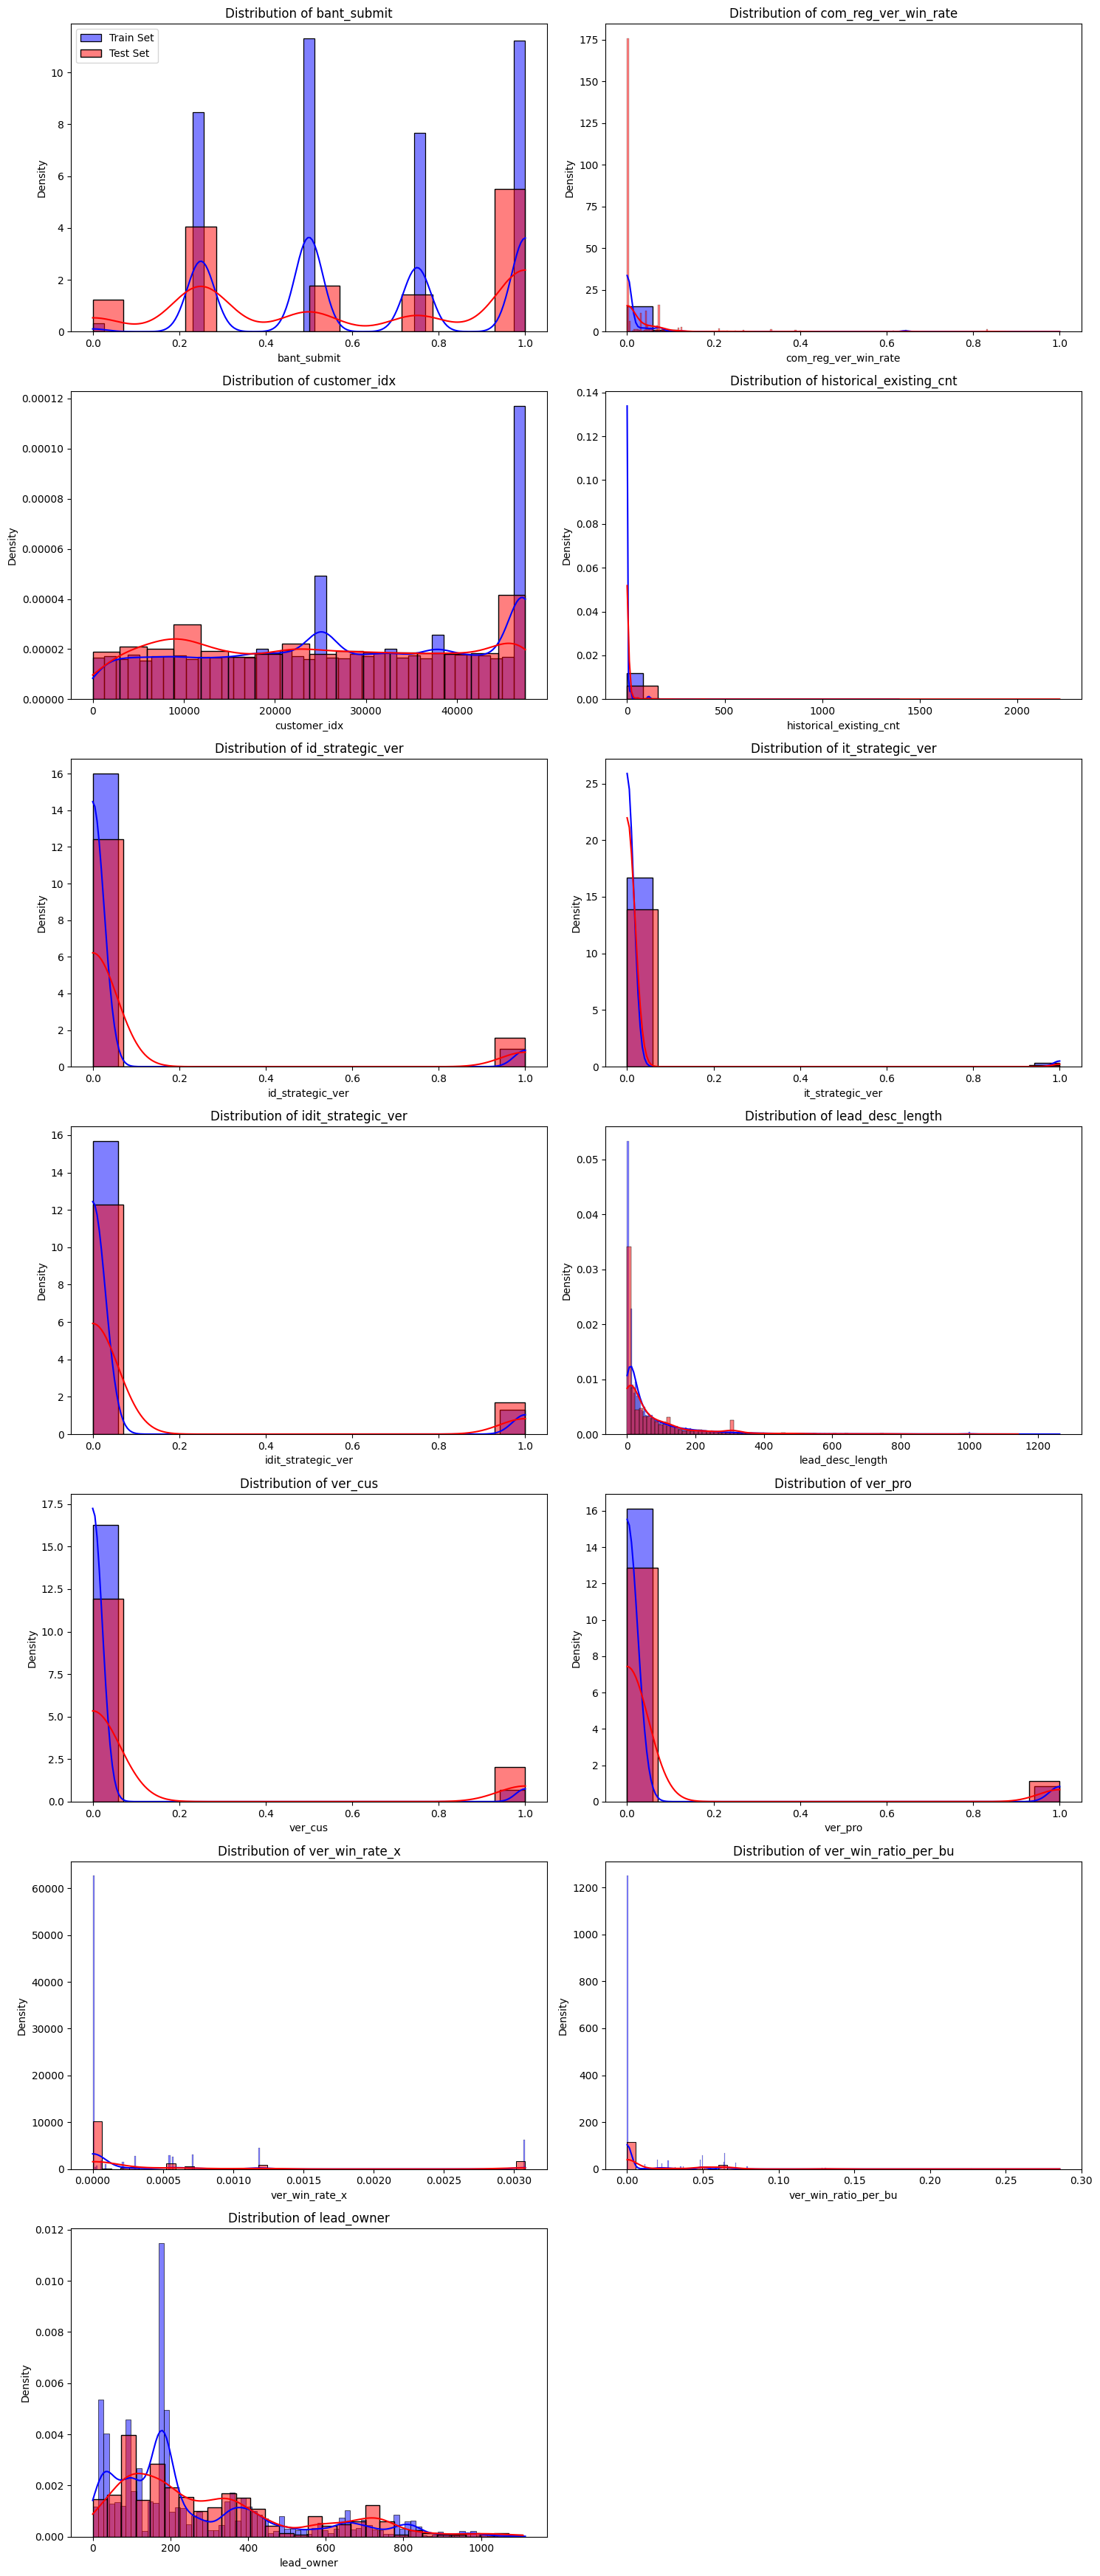

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


numeric_columns = train_x.select_dtypes(include=['float', 'int']).columns
n_cols = 2
n_rows = len(numeric_columns) // n_cols + (len(numeric_columns) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(train_x[column], color="blue", kde=True, label='Train Set', alpha=0.5, stat="density")
    sns.histplot(test_x[column], color="red", kde=True, label='Test Set', alpha=0.5, stat="density")

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    if i == 1:
        plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [48]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# label_columns = [
#     "customer_country", "business_subarea", "business_area",
#     "business_unit", "customer_type", "enterprise",
#     "customer_job", "inquiry_type", "product_category",
#     "customer_position", "response_corporate", "expected_timeline", "lead_owner"
# ]

# n_cols = 2
# n_rows = len(label_columns) // n_cols + (len(label_columns) % n_cols > 0)

# plt.figure(figsize=(15, 5 * n_rows))

# for i, column in enumerate(label_columns, 1):
#     plt.subplot(n_rows, n_cols, i)

#     sns.histplot(train_encoded[column], color="blue", kde=True, label='Train Set', alpha=0.5, stat="density")
#     sns.histplot(test_encoded[column], color="red", kde=True, label='Test Set', alpha=0.5, stat="density")

#     plt.title(f'Distribution of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Density')
#     if i == 1:
#         plt.legend()

# plt.subplots_adjust(hspace=0.5)
# plt.tight_layout()
# plt.show()

<ipython-input-49-75e4c9d5c177>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, n_cols, i)


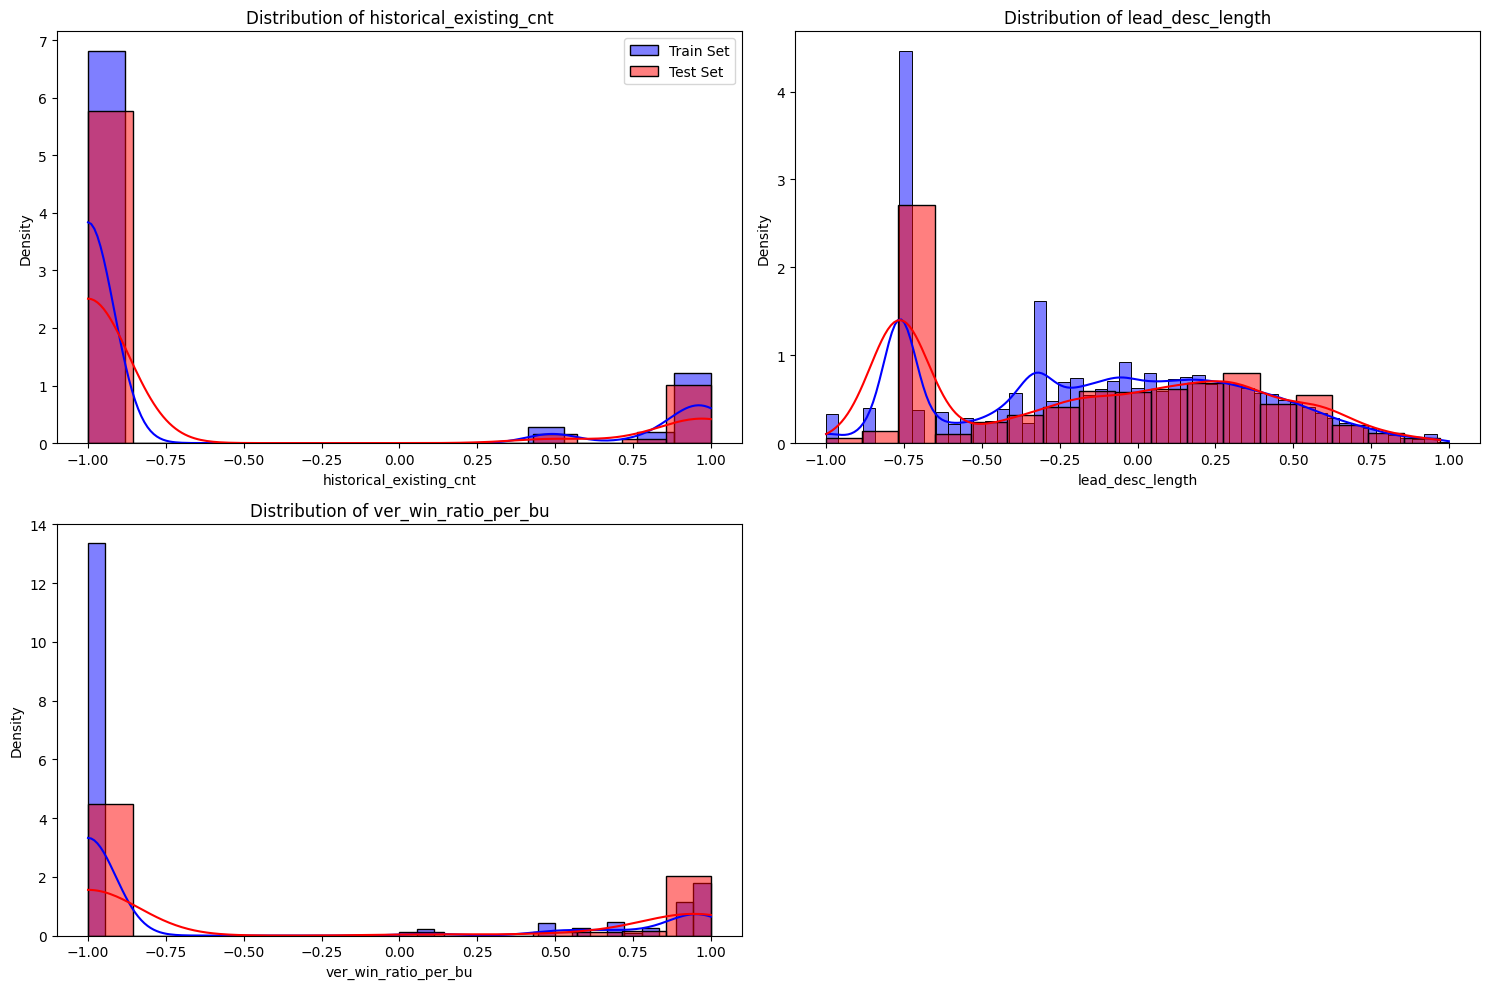

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#numeric_columns = train_x.select_dtypes(include=['float', 'int']).columns
n_cols = 2
n_rows = len(numeric_columns1) // n_cols + (len(numeric_columns1) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))
plt.title('전체 변환 후')
for i, column in enumerate(numeric_columns1, 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(train_6f[column], color="blue", kde=True, label='Train Set', alpha=0.5, stat="density")
    sns.histplot(test_6f[column], color="red", kde=True, label='Test Set', alpha=0.5, stat="density")

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    if i == 1:
        plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [50]:
train_6f

,bant_submit,expected_timeline,ver_win_ratio_per_bu,business_unit,business_area,business_subarea,customer_type,customer_job,customer_country,product_category,lead_desc_length,response_corporate,lead_owner,historical_existing_cnt,is_converted
0,1.00,0,0.674311,0,0,0,0,0,0,0,0.123642,0,0,-1.000000,True
1,1.00,0,0.674311,0,0,1,0,1,0,0,0.255241,0,1,0.987368,True
2,1.00,0,0.674311,0,0,2,0,2,1,1,0.092850,1,2,0.999893,True
3,1.00,0,0.674311,0,0,3,0,3,1,2,0.019708,1,3,-1.000000,True
4,1.00,0,0.674311,0,0,4,1,4,1,0,0.258346,1,4,-1.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,2,0.713653,0,12,11,0,2,46,2,0.473117,27,694,-1.000000,False
59295,0.75,3,0.713653,0,12,4,1,3,9,4,0.160286,9,39,-1.000000,False
59296,0.75,0,0.713653,0,12,4,1,2,41,1,-0.058694,23,125,-1.000000,False
59297,1.00,4,0.713653,0,12,4,4,3,41,4,0.657709,23,134,-1.000000,False


In [51]:
test_6f

,bant_submit,expected_timeline,ver_win_ratio_per_bu,business_unit,business_area,business_subarea,customer_type,customer_job,customer_country,product_category,lead_desc_length,response_corporate,lead_owner,historical_existing_cnt,is_converted
0,0.00,1,0.928573,1,8,46,0,4,5,-9,-0.763651,5,278,0.999242,True
1,0.25,1,-1.000000,2,11,11,0,9,8,-9,-0.177648,8,437,-1.000000,True
2,1.00,0,0.999569,1,4,33,1,12,6,35,0.363491,6,874,-1.000000,False
3,0.50,4,0.928573,1,8,4,4,6,8,-9,-0.763651,8,194,-1.000000,False
4,1.00,0,0.972495,1,0,0,0,2,5,19,0.287701,5,167,0.771470,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.50,1,-1.000000,0,1,4,4,6,5,-9,-0.532753,5,97,0.982431,False
5267,0.25,1,-1.000000,2,1,4,4,9,8,-9,0.401726,8,438,-1.000000,False
5268,0.75,0,-1.000000,0,1,4,1,3,5,0,-0.016954,5,97,-1.000000,True
5269,0.00,1,-1.000000,2,1,4,0,9,8,-9,-0.763651,24,429,-1.000000,False


In [52]:
# var1 = 'bant_submit, expected_timeline, business_unit, enterprise, customer_idx, ver_cus, ver_win_ratio_per_bu, business_area, business_subarea, product_category, customer_job, \
# lead_desc_length, customer_position, customer_type, response_corporate, lead_owner, inquiry_type, is_converted'.split(', ')

# var2 = 'bant_submit, expected_timeline, business_unit, enterprise, ver_cus, ver_win_ratio_per_bu, business_area, business_subarea, product_category, customer_job, \
# lead_desc_length, customer_position, customer_type, response_corporate, lead_owner, inquiry_type, is_converted'.split(', ')

# var3 = 'bant_submit, expected_timeline, business_unit, enterprise, ver_cus, ver_win_ratio_per_bu, business_area, business_subarea, product_category, customer_job, \
# lead_desc_length, customer_position, customer_type, response_corporate, lead_owner, inquiry_type, is_converted, customer_country, com_reg_ver_win_rate, historical_existing_cnt, \
# ver_win_rate_x, customer_idx, id_strategic_ver, it_strategic_ver, idit_strategic_ver, ver_pro'.split(', ')

# var4 = ['bant_submit', 'expected_timeline', 'enterprise',
#        'ver_win_ratio_per_bu', 'business_subarea', 'product_category',
#        'customer_job', 'lead_desc_length', 'customer_position',
#        'customer_type', 'response_corporate', 'lead_owner', 'inquiry_type',
#        'customer_country', 'com_reg_ver_win_rate', 'historical_existing_cnt',
#        'ver_win_rate_x', 'is_converted']

# var5 = ['bant_submit', 'expected_timeline', 'business_unit',
#        'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
#        'customer_job', 'lead_desc_length', 'response_corporate', 'lead_owner',
#        'historical_existing_cnt', 'is_converted']

# var6 = 'bant_submit, expected_timeline, ver_win_ratio_per_bu, business_unit, business_area, business_subarea, customer_type, customer_job, \
# customer_country, product_category, lead_desc_length, response_corporate, lead_owner, historical_existing_cnt, is_converted'.split(', ')

# var7 = ['bant_submit', 'expected_timeline', 'business_unit',
#        'ver_win_ratio_per_bu', 'business_subarea', 'customer_job',
#        'lead_desc_length', 'lead_owner', 'customer_idx']

# var8 = ['bant_submit', 'expected_timeline', 'enterprise',
#        'ver_win_ratio_per_bu', 'customer_job', 'lead_desc_length',
#        'response_corporate', 'lead_owner', 'customer_idx']

In [53]:
# coll = var3
# train_6ff = train_6f[coll]
# test_6ff = test_6f[coll]

In [54]:
# from sklearn.feature_selection import RFE, RFECV
# from sklearn.model_selection import train_test_split, GridSearchCV
# import lightgbm as lgb
# from sklearn.metrics import make_scorer, recall_score, f1_score

# x_train, x_val, y_train, y_val = train_test_split(
#     train_6ff.drop("is_converted", axis=1),
#     train_6ff["is_converted"],
#     test_size=0.2,
#     shuffle=True,
#     random_state=230,
# )

# lgb_clf = lgb.LGBMClassifier(random_state=123, max_depth=8, learning_rate=0.2, n_estimators=700, subsample=0.6, scale_pos_weight=11.2265, importance_type='gain')

# selector = RFECV(lgb_clf, min_features_to_select=9, step=1, cv=3)
# selector = selector.fit(x_train, y_train)

# selected_columns = x_train.columns[selector.support_]
# selected_columns

In [55]:
# selector.n_features_


1. grid_search
2. optuna

In [56]:
coll3 = var1
train_6ff = train_6f[coll3]
test_6ff = test_6f[coll3]

In [57]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

x_train, x_val, y_train, y_val = train_test_split(
    train_6ff.drop("is_converted", axis=1),
    train_6ff["is_converted"],
    test_size=0.1,
    shuffle=True,
    random_state=230,
    stratify=train_6ff["is_converted"]
)

# Optuna 최적화 함수 정의
def objective(trial):
    param = {
        'min_split_gain': trial.suggest_float('min_split_gain', 0.3, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 128, 256),
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1200),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'scale_pos_weight': 11.2265,
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.75),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.75),
        'random_state': 123,
        'boosting_type': 'dart',
        'skip_drop': 0.5
    }

    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)
    model = lgb.LGBMClassifier(**param)

    score = cross_val_score(model, x_train, y_train, cv=stratified_kfold, scoring='f1_macro').mean()

    #model.fit(x_train, y_train, eval_set=[(x_val, y_val)], cv=stratified_kfold)
    #preds = model.predict(x_val)
    #f1 = f1_score(y_val, preds)
    return score

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

# 최적의 파라미터 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-26 03:01:35,850] A new study created in memory with name: no-name-0c93a1be-3693-44e7-889b-0e146de6740f


[LightGBM] [Info] Number of positive: 2910, number of negative: 32669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 35579, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081790 -> initscore=-2.418274
[LightGBM] [Info] Start training from score -2.418274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-02-26 03:06:56,473] Trial 0 finished with value: 0.7929739368251979 and parameters: {'min_split_gain': 0.3084053391882845, 'num_leaves': 191, 'subsample': 0.591476597948296, 'learning_rate': 0.18253546614281368, 'n_estimators': 1150, 'max_depth': 5, 'reg_alpha': 0.2813361525655621, 'reg_lambda': 0.10589101196835995}. Best is trial 0 with value: 0.7929739368251979.


[LightGBM] [Info] Number of positive: 2910, number of negative: 32669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1005
[LightGBM] [Info] Number of data points in the train set: 35579, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081790 -> initscore=-2.418274
[LightGBM] [Info] Start training from score -2.418274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-02-26 03:14:39,576] Trial 1 finished with value: 0.8125045196575983 and parameters: {'min_split_gain': 0.3153179916583105, 'num_leaves': 218, 'subsample': 0.41095989256396936, 'learning_rate': 0.1515400826353761, 'n_estimators': 1171, 'max_depth': 7, 'reg_alpha': 0.3030491871463856, 'reg_lambda': 0.4793432977129826}. Best is trial 1 with value: 0.8125045196575983.


Number of finished trials: 2
Best trial: {'min_split_gain': 0.3153179916583105, 'num_leaves': 218, 'subsample': 0.41095989256396936, 'learning_rate': 0.1515400826353761, 'n_estimators': 1171, 'max_depth': 7, 'reg_alpha': 0.3030491871463856, 'reg_lambda': 0.4793432977129826}


In [58]:
#case1 : var1 = 'bant_submit, customer_country, business_unit, enterprise, \
# lead_desc_length, customer_position, response_corporate, lead_owner, inquiry_type, is_converted'.split(', ')
# from sklearn.model_selection import train_test_split, GridSearchCV
# import lightgbm as lgb
# from sklearn.metrics import make_scorer, recall_score, f1_score

# x_train, x_val, y_train, y_val = train_test_split(
#     train_6ff.drop("is_converted", axis=1),
#     train_6ff["is_converted"],
#     test_size=0.0,
#     shuffle=True,
#     random_state=230,
# )


# lgb_clf = lgb.LGBMClassifier(random_state=123)
# lgb_clf = lgb.LGBMClassifier(random_state=123, boosting_type='dart', skip_drop=0.5)

# param_grid = {
#     'max_depth': [7],
#     'min_split_gain': [0.3090656521849622],
#     'num_leaves': [229],
#     'reg_alpha': [0.46185158756475886],
#     'reg_lambda': [0.06397141819686661],
#     'learning_rate': [0.06159502783007274],
#     'n_estimators': [1081],
#     'subsample': [0.5831852332544936],
#     'scale_pos_weight' : [11.2265],
# }

# grid_search5 = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='f1', verbose=1)
# grid_search5.fit(x_train, y_train)

# print("Best Parameters:", grid_search5.best_params_)
# print("Best Score:", grid_search5.best_score_)

In [59]:
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, precision_score

model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model.fit(x_train, y_train)

y_pred4 = model.predict(x_val)
print(f1_score(y_val, y_pred4))
print(accuracy_score(y_val, y_pred4))
print(precision_score(y_val, y_pred4))
print(recall_score(y_val, y_pred4))

[LightGBM] [Info] Number of positive: 4365, number of negative: 49004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 53369, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081789 -> initscore=-2.418284
[LightGBM] [Info] Start training from score -2.418284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [60]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# best_model5 = grid_search5.best_estimator_
# y_pred4 = best_model5.predict(x_val)
# print(f1_score(y_val, y_pred4))
# print(accuracy_score(y_val, y_pred4))
# print(precision_score(y_val, y_pred4))
# print(recall_score(y_val, y_pred4))

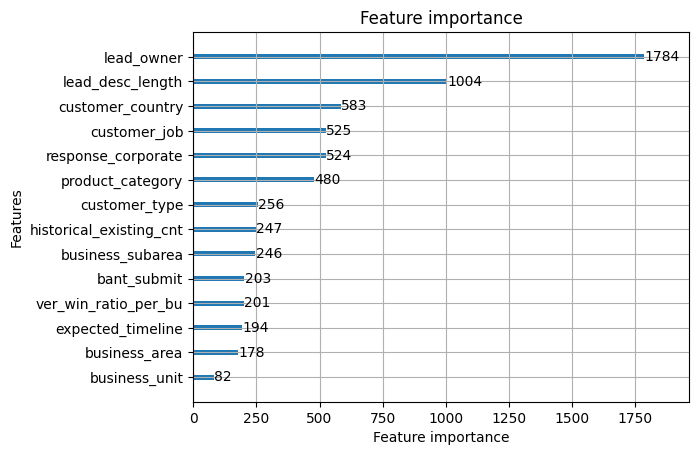

In [61]:
from lightgbm import plot_importance
ax = plot_importance(model)

In [62]:
x_test = test_6ff.drop(["is_converted"], axis=1)
# 테스트 데이터셋에 대한 예측 수행
y_pred = model.predict(x_test)

#df_sub = pd.read_csv("../submission.csv")
#df_sub["is_converted"] = y_pred3
#df_sub.to_csv("submission0213_1.csv", index=False)
y_pred.sum() #기본 임계값

492

In [76]:
y_pred_proba = model.predict_proba(x_test)[:, 1]
threshold = 0.08

y_pred_custom_threshold = np.where(y_pred_proba > threshold, 1, 0)
y_pred_custom_threshold.sum()

2004

In [77]:
df_check = pd.read_csv("/content/drive/My Drive/lg_aimers/submission0217_2_008.csv")

In [78]:
sum(df_check['is_converted']==y_pred_custom_threshold)

4658

In [79]:
df_sub = pd.read_csv("/content/drive/My Drive/lg_aimers/original_submission.csv")
df_sub["is_converted"] = y_pred_custom_threshold
df_sub.to_csv("/content/drive/My Drive/lg_aimers/submission0225_2.csv", index=False)